Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Clean Graph: 31 nodes, 31 edges
Infected Graph: 31 nodes, 34 edges
Using device: cpu
Epoch 0, Loss: 0.0492
Epoch 10, Loss: 0.0070
Epoch 20, Loss: 0.0015
Epoch 30, Loss: 0.0011
Epoch 40, Loss: 0.0004
Epoch 50, Loss: 0.0003
Epoch 60, Loss: 0.0002
Epoch 70, Loss: 0.0001
Epoch 80, Loss: 0.0001
Epoch 90, Loss: 0.0001


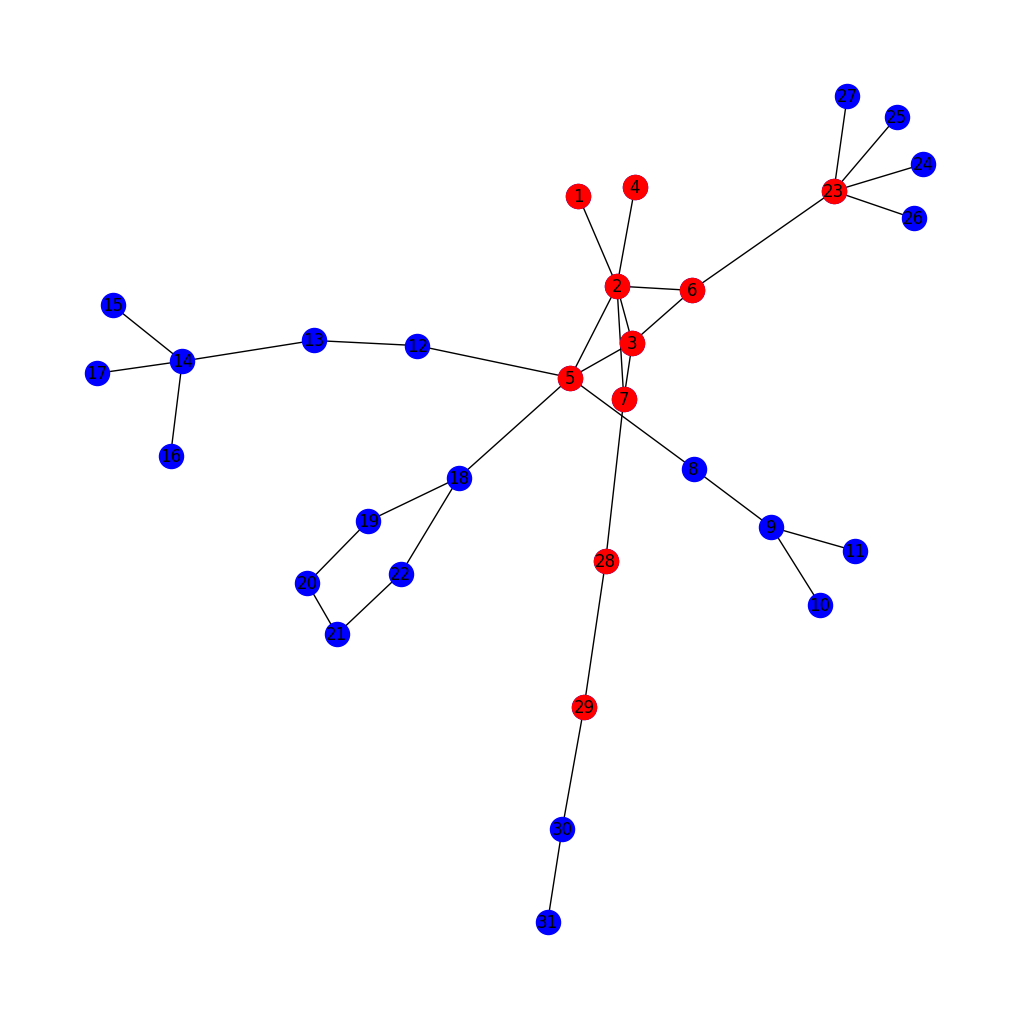

Centrality measures for clean graph:
   Degree Centrality  Betweenness Centrality  Closeness Centrality  \
1           0.033333                0.000000              0.258621   
2           0.200000                0.666667              0.344828   
3           0.033333                0.000000              0.258621   
4           0.033333                0.000000              0.258621   
5           0.133333                0.687356              0.348837   

   Eigenvector Centrality  Clustering Coefficient  
1                0.203284                       0  
2                0.561154                       0  
3                0.203284                       0  
4                0.203284                       0  
5                0.417677                       0  
Centrality measures for infected graph:
   Degree Centrality  Betweenness Centrality  Closeness Centrality  \
1           0.033333                0.000000              0.258621   
2           0.200000                0.367816      

In [6]:
# Install required packages
!pip install torch torch-geometric pyvis

# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import logging
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the file paths for each CSV file
file_paths = {
    'clean_nodes': '/content/drive/My Drive/ICS_OT Nodes.csv',
    'clean_edges': '/content/drive/My Drive/ICS_OT Edges.csv',
    'infected_nodes': '/content/drive/My Drive/ICS_OT NodesInfected.csv',
    'infected_edges': '/content/drive/My Drive/ICS_OT EdgesInfected.csv',
}

# Load the CSV files into separate pandas DataFrames
clean_nodes_df = pd.read_csv(file_paths['clean_nodes'])
clean_edges_df = pd.read_csv(file_paths['clean_edges'])
infected_nodes_df = pd.read_csv(file_paths['infected_nodes'])
infected_edges_df = pd.read_csv(file_paths['infected_edges'])


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the CSV files from Google Drive
def load_graph(nodes_file, edges_file):
    """Load graph data from CSV files."""
    try:
        nodes_df = pd.read_csv(nodes_file)
        edges_df = pd.read_csv(edges_file)
        G = nx.Graph()

        # Add nodes with features
        for index, row in nodes_df.iterrows():
            G.add_node(row['Id'], label=row['Label'], shape=row.get('Shape', 'ellipse'))

        # Add edges
        for index, row in edges_df.iterrows():
            G.add_edge(row['Source'], row['Target'], weight=row.get('Weight', 1))

        return G, nodes_df, edges_df
    except Exception as e:
        logging.error(f"Error loading graph: {str(e)}")
        return None, None, None

# Load the clean and infected graphs
G_clean, clean_nodes_df, clean_edges_df = load_graph(file_paths['clean_nodes'], file_paths['clean_edges'])
G_infected, infected_nodes_df, infected_edges_df = load_graph(file_paths['infected_nodes'], file_paths['infected_edges'])

# Check if graphs loaded successfully
if G_clean is None or G_infected is None:
    raise Exception("Error loading graphs from the files. Please check the paths.")

# Compute node centrality measures as features
def calculate_centrality(G):
    """Calculate centrality measures for each node."""
    centrality_measures = {
        'Degree Centrality': nx.degree_centrality(G),
        'Betweenness Centrality': nx.betweenness_centrality(G),
        'Closeness Centrality': nx.closeness_centrality(G),
        'Eigenvector Centrality': nx.eigenvector_centrality(G),
        'Clustering Coefficient': nx.clustering(G)
    }
    return pd.DataFrame(centrality_measures).sort_index()

# Prepare graph data for PyTorch Geometric
def prepare_graph_data(G):
    """Prepare node features and edge indices for PyTorch Geometric."""
    edge_index_np = np.array(list(G.edges)).T  # Convert edges to numpy array
    edge_index = torch.tensor(edge_index_np, dtype=torch.long)  # Convert edges to tensor

    # Adjust edge index to be zero-based (if needed)
    edge_index -= 1  # Ensure all edge indices are zero-based

    # Calculate centrality measures and use as node features
    centrality_df = calculate_centrality(G)
    features = torch.tensor(centrality_df.values, dtype=torch.float)  # Convert features to tensor

    return features, edge_index

# Prepare graph data for both clean and infected networks
clean_features, clean_edge_index = prepare_graph_data(G_clean)
infected_features, infected_edge_index = prepare_graph_data(G_infected)

# Print summary of the loaded data
print(f"Clean Graph: {G_clean.number_of_nodes()} nodes, {G_clean.number_of_edges()} edges")
print(f"Infected Graph: {G_infected.number_of_nodes()} nodes, {G_infected.number_of_edges()} edges")

# Create PyTorch Geometric Data for clean and infected graphs
clean_data = Data(x=clean_features, edge_index=clean_edge_index)
infected_data = Data(x=infected_features, edge_index=infected_edge_index)

# Check device (CUDA or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Transfer data to the appropriate device
clean_data = clean_data.to(device)
infected_data = infected_data.to(device)

# Define the GraphSAGE model
class GraphSAGEModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        # Initialize the SAGEConv layers with the correct input arguments
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the GraphSAGE model
in_channels = clean_features.shape[1]  # Number of centrality measures as input features
hidden_channels = 64
out_channels = clean_features.shape[1]  # Must match the number of input features (5 in this case)

model = GraphSAGEModel(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training function
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.x)  # Using node features as target for unsupervised training
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
@torch.no_grad()
def evaluate_embeddings(model, data_clean, data_infected):
    model.eval()
    clean_emb = model(data_clean)
    infected_emb = model(data_infected)

    # Compute difference in embeddings
    diff = torch.norm(clean_emb - infected_emb, dim=1)
    return diff

# Training loop
epochs = 100
for epoch in range(epochs):
    loss = train(model, optimizer, clean_data)
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# Evaluate embeddings
embedding_diff = evaluate_embeddings(model, clean_data, infected_data)

# Map top_anomalous_nodes to actual node IDs in the graph
def map_anomalous_nodes_to_ids(G, anomalous_indices):
    node_list = list(G.nodes())
    return [node_list[i] for i in anomalous_indices]

# Visualize the top anomalous nodes with the correct node IDs
def visualize_anomalous_nodes(G, anomalous_indices):
    """Visualize top anomalous nodes."""
    anomalous_ids = map_anomalous_nodes_to_ids(G, anomalous_indices)
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 10))
    nx.draw(G, pos, node_color='blue', with_labels=True)
    nx.draw_networkx_nodes(G, pos, nodelist=anomalous_ids, node_color='red')
    plt.show()

# Visualize top anomalous nodes in the infected graph
anomalous_node_ids = map_anomalous_nodes_to_ids(G_infected, top_anomalous_nodes.tolist())
visualize_anomalous_nodes(G_infected, top_anomalous_nodes.tolist())

# Calculate centrality measures for the clean graph
centrality_clean = calculate_centrality(G_clean)
print("Centrality measures for clean graph:")
print(centrality_clean.head())

# Calculate centrality measures for the infected graph
centrality_infected = calculate_centrality(G_infected)
print("Centrality measures for infected graph:")
print(centrality_infected.head())
